In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
nx = 10
ny = 12

# in-plane coordinates of rectangle-centers (where data is defined)
x_plane = np.linspace(0, 1, nx)
y_plane = np.linspace(0, 1, ny)

# data at rectangle centers
data = np.random.rand(x_plane.size, y_plane.size)

# in-plane grid spacing 
dx = x_plane[1] - x_plane[0]
dy = y_plane[1] - y_plane[0]

# in-plane rectangle edges (the bounds of the future frb)
x_plane_e = np.append(x_plane - dx/2., x_plane[-1] + dx/2.)
y_plane_e = np.append(y_plane - dy/2., y_plane[-1] + dy/2.)

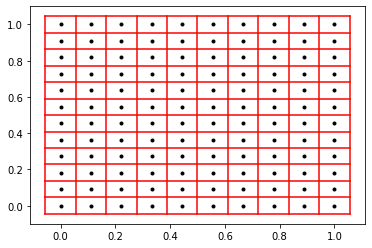

In [10]:
xc, yc = np.meshgrid(x_plane, y_plane)
plt.plot(xc.ravel(),yc.ravel(),'.k')

for x in x_plane_e:
    plt.plot(np.full(y_plane_e.shape, x),y_plane_e,'r')
    
for y in y_plane_e:
    plt.plot(x_plane_e, np.full(x_plane_e.shape, y),'r')    

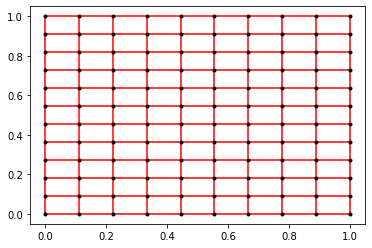

In [11]:
# but we'll treat each point as a vertex instead

xc, yc = np.meshgrid(x_plane, y_plane)


for x in x_plane:
    plt.plot(np.full(y_plane.shape, x),y_plane,'r')
    
for y in y_plane:
    plt.plot(x_plane, np.full(x_plane.shape, y),'r')    
    
plt.plot(xc.ravel(),yc.ravel(),'.k')

In [12]:
# do the triangulation in-plane 

# Brute force (bad)
Nrect_x = (x_plane.size - 1)
Nrect_y = (y_plane.size - 1)
tri_verts = []
nverts = 0 
tri_data = []
tri_conn = []
for i_x in range(Nrect_x):
    for i_y in range(Nrect_y):
        # first triangle (bottom left)
        tri_verts.append(np.array([
                                [x_plane[i_x], y_plane[i_y], 0],
                                [x_plane[i_x+1], y_plane[i_y], 0],
                                [x_plane[i_x], y_plane[i_y+1], 0],
                         ]))
        
        tri_data.append([data[i_x, i_y], data[i_x+1, i_y], data[i_x, i_y+1]])
        tri_conn.append([nverts, nverts+1, nverts+2])
        nverts += 3
        
        # second triangle (top right)
        tri_verts.append(np.array([
                                [x_plane[i_x+1], y_plane[i_y+1], 0],
                                [x_plane[i_x+1], y_plane[i_y], 0],
                                [x_plane[i_x], y_plane[i_y+1], 0],
                         ]))
        
        tri_data.append([data[i_x+1, i_y+1], data[i_x+1, i_y], data[i_x, i_y+1]])
        tri_conn.append([nverts, nverts+1, nverts+2])
        nverts += 3
        
tri_verts = np.array(tri_verts)        
tri_data = np.array(tri_data)
tri_conn = np.array(tri_conn)

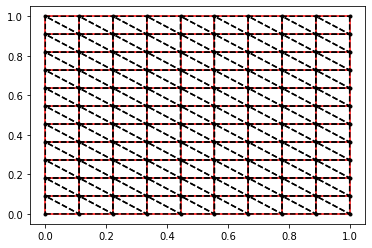

In [13]:
xc, yc = np.meshgrid(x_plane, y_plane)

for x in x_plane:
    plt.plot(np.full(y_plane.shape, x),y_plane,'r')
    
for y in y_plane:
    plt.plot(x_plane, np.full(x_plane.shape, y),'r')    
    
plt.plot(xc.ravel(),yc.ravel(),'.k')

for tri in tri_verts:
    x_tris = np.append(tri[:, 0],tri[0, 0])
    y_tris = np.append(tri[:, 1],tri[0, 1])
    plt.plot(x_tris, y_tris, '--k')

In [54]:
# now we need to transform from the in-plane coordinates to 3D 
# our x_plane and z_plane are a coordinate

# assume we have our plane definition from eleswhere (e.g., yt's slice object)
normal_vec = np.array([1, 0, 0]) 
plane_origin = np.array([0.5, 0, 0])
plane_width = 2
plane_height = 2

# our basis vectors for the above plane:
P0 = plane_origin - np.array([0., plane_width/2, 0.]) - np.array([0., 0., plane_height/2])
P1 = P0 + np.array([0., 0., plane_height])
P2 = P0 + np.array([0., plane_width, 0.])
u = P1 - P0  # u = a * x + b * y + c * z
v = P2 - P0
print(P0)
print(u)
print(v)

[ 0.5 -1.  -1. ]
[0. 0. 2.]
[0. 2. 0.]


In [49]:
tri_verts[10][:][1]

array([0.11111111, 0.45454545, 0.        ])

In [50]:
tri_verts[10][:][1][0]

0.1111111111111111

In [51]:
# position
single_tri = tri_verts[10][:][1]
u_0 = single_tri[0]
v_0 = single_tri[1]
n_0 = single_tri[2]
(u_0, v_0, n_0)

(0.1111111111111111, 0.4545454545454546, 0.0)

In [55]:
u_0 * u + v_0 * v + n_0 * normal_vec + P0

array([ 0.5       , -0.09090909, -0.77777778])

In [71]:
xyz_verts = []
for single_tri in tri_verts:    
    for vert in single_tri:        
        u_0 = vert[0]
        v_0 = vert[1]
        n_0 = vert[2]
        xyz_verts.append(u_0 * u + v_0 * v + n_0 * normal_vec + P0)
    
xyz_verts = np.array(xyz_verts)

In [72]:
xyz_verts

array([[ 0.5       , -1.        , -1.        ],
       [ 0.5       , -1.        , -0.77777778],
       [ 0.5       , -0.81818182, -1.        ],
       ...,
       [ 0.5       ,  1.        ,  1.        ],
       [ 0.5       ,  0.81818182,  1.        ],
       [ 0.5       ,  1.        ,  0.77777778]])

In [76]:
xyz_verts[:,1].shape

(594,)

In [79]:
tri_data.ravel().shape

(594,)

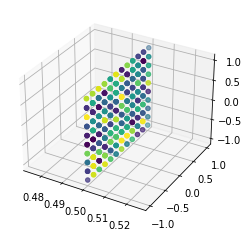

In [81]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xyz_verts[:,0], xyz_verts[:,1], xyz_verts[:,2], '.', c=tri_data.ravel())

In [328]:
# vecgtorized (fast!) plane triangulation

def triangulate_plane(u_vec, v_vec, data):
     
    Nrect_u = (u_vec.size - 1)
    Nrect_v = (v_vec.size - 1)
    Nrects = Nrect_u * Nrect_v # number of rectangles to split
    Ntris = Nrects * 2 # every rectangle -> 2 triangles
    Nverts = Ntris * 3 # every triangle has 3 vertices

    print(Ntris)
    # in-plane coordinates
    u_i, v_i = np.meshgrid(u_vec, v_vec)
    u_i = u_i.ravel()
    v_i = v_i.ravel()

    if data.ndim != 1:
        data_i = data.ravel()
    else:
        data_i = data

    if data_i.size != u_i.size:
        raise ValueError("data is not the right size")

    # our triangle sampling stencil
    rect_i = np.arange(0, Nrects)
    rect_i += np.floor(rect_i / Nrect_u).astype('int')  # offset by row (every row introduces an offset of 1)

    lower_left =  rect_i
    lower_right = rect_i + 1
    upper_left = rect_i + u_vec.size
    upper_right = rect_i + u_vec.size + 1

    # get the positions of all the verts
    lower_left_uv = np.column_stack([u_i[lower_left], v_i[lower_left]])
    lower_right_uv = np.column_stack([u_i[lower_right], v_i[lower_right]])
    upper_left_uv = np.column_stack([u_i[upper_left], v_i[upper_left]])
    upper_right_uv = np.column_stack([u_i[upper_right], v_i[upper_right]])

    # stack them in the right way
    
    # concatenate all the vertices then re-sample to end up with (Nrects, 2, 3)
    low_tris = np.concatenate([lower_left_uv, lower_right_uv, upper_left_uv]) 
    
    i_conn = np.arange(0, Nrects)
    i_conn = np.column_stack([i_conn, i_conn+i_conn.size, i_conn + i_conn.size*2])
    i_conn = np.concatenate([i_conn, i_conn+i_conn.size])
    
#     low_tris = low_tris[i_conn]   
    
    low_tri_data = np.array([data_i[lower_left], data_i[lower_right], data_i[upper_left]])

    up_tris = np.concatenate([upper_right_uv, lower_right_uv, upper_left_uv])
#     up_tris = up_tris[i_conn]
    
    up_tri_data = np.array([data_i[upper_right], data_i[lower_right], data_i[upper_left]])

    tri_verts = np.concatenate([low_tris, up_tris])
    tri_data = np.concatenate([low_tri_data.T, up_tri_data.T])

    return tri_verts, tri_data, i_conn

In [329]:
nu = 10
nv = 12

# in-plane coordinates of rectangle-centers (where data is defined)
x_plane = np.linspace(0, 1, nu)
y_plane = np.linspace(0, 1, nv)

# data at rectangle centers
data = np.random.rand(x_plane.size, y_plane.size)

triangles, vert_data, i_conn = triangulate_plane(x_plane, y_plane, data)

198


In [330]:
triangles.shape

(594, 2)

In [331]:
i_conn.shape

(198, 3)

In [309]:
verts[0][:,1]

array([0.        , 0.        , 0.04166667])

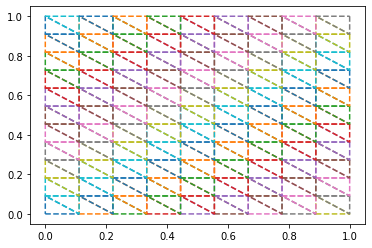

In [332]:
for conn in i_conn:
    verts = triangles[conn]
    X = verts[:,0]
    Y = verts[:,1]    
    plt.plot(np.append(X, X[0]), np.append(Y, Y[0]), '--')

In [312]:
%%time 

nu = 1500
nv = 2600

# in-plane coordinates of rectangle-centers (where data is defined)
x_plane = np.linspace(0, 1, nu)
y_plane = np.linspace(0, 1, nv)

# data at rectangle centers
data = np.random.rand(x_plane.size, y_plane.size)

verts, vert_data = triangulate_plane(x_plane, y_plane, data)

CPU times: user 510 ms, sys: 155 ms, total: 665 ms
Wall time: 665 ms


ok, then the vertex shader can handle the transformation from the in-plain coords to the 3D world coords.
